In [29]:
import os
import shutil
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import torch.optim as optim

In [30]:
# Part 1a: Load images in folder
'''Desktop/
└── Razorback_CNN_Project/
    ├── data/                    # All images here
    │   ├── Razorback1-26.jpg    # Official logos
    │   └── Pic1-26.jpg          # Non-official images
    ├── dataset/                 # Auto-created by code
    │   ├── official/           # Organized images
    │   └── not_official/
    └── razorback_cnn.ipynb     # main code'''

source_folder = "data"       # raw images folder
dataset_folder = "dataset"   # final structured dataset

# Create labeled folders in "dataset" folder above
official_dir = os.path.join(dataset_folder, "official")
not_official_dir = os.path.join(dataset_folder, "not_official")

os.makedirs(official_dir, exist_ok=True)
os.makedirs(not_official_dir, exist_ok=True)

# Check files and copy to appropriate label folder
for file in os.listdir(source_folder):
    file_path = os.path.join(source_folder, file)

    if not file.lower().endswith(".jpg"):
        continue

    # Razorback images
    if file.startswith("Razorback") or file == "Razorback_official.jpg":
        shutil.copy(file_path, official_dir) # Moves razorback images to Desktop/data/dataset/official

    # Non-official images
    elif file.startswith("Pic"):
        shutil.copy(file_path, not_official_dir) # Moves non-razorback images to Desktop/data/dataset/not_official

print(f"# of official images: {len(os.listdir(official_dir))}")
print(f"# of not-official images: {len(os.listdir(not_official_dir))}")

# of official images: 26
# of not-official images: 26


In [31]:
# Part 1b: Load data with PyTorce

# Resize images to 500x500
train_transform = transforms.Compose([
        transforms.Resize((500, 500)),
        transforms.RandomHorizontalFlip(p=0.2),  # Even less augmentation
        transforms.RandomRotation(2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize((500, 500)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Load full dataset
dataset = datasets.ImageFolder(root=dataset_folder, transform=train_transform)

print("Classes found:", dataset.classes)
print("Total images loaded:", len(dataset))

Classes found: ['not_official', 'official']
Total images loaded: 52


In [32]:
# Part 1c: Train/test split & data loaders

# 70% train, 15% validation, 15% test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42))

# build data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True) # reduced batch size from 8
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False) # reduced batch size from 8
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

print(f"Train images: {len(train_dataset)}")
print(f"Test images:  {len(test_dataset)}")

Train images: 36
Test images:  9


In [33]:
# Training loop
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Part 2b: Create CNN Architecture
class RazorbackCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        
        self.features = nn.Sequential(
            # 1st conv block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            #nn.BatchNorm2d(32),  # Added batch norm
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # 2nd conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # 3rd conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Dropout2d(dropout_rate),
            nn.AdaptiveAvgPool2d((6, 6))  # increased from 4x4
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 128), # reduced from 256
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 2)#,
            #nn.ReLU(),
            #nn.Dropout(dropout_rate/2),
            #nn.Linear(64, 2)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = RazorbackCNN().to(device)
print(model)

Using device: cpu
RazorbackCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.5, inplace=False)
    (10): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4608, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [34]:
# Part 2c: training setup

# Better optimizer and learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Added weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# Train/test functions
def train_model():
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc = 100 * correct / total
    return running_loss / len(train_loader), train_acc

def test_model(data_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = 100 * correct / total
    return accuracy, all_preds, all_labels

In [35]:
# Train w early stopping

EPOCHS = 30 # increased from 10
best_val_acc = 0
patience = 8
patience_counter = 0
train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_model()
    val_acc, _, _ = test_model(val_loader)
    
    scheduler.step(train_loss)  # Update learning rate based on training loss
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1:2d}/{EPOCHS} | "
          f"Train loss: {train_loss:.4f} | "
          f"Train acc: {train_acc:.2f}% | "
          f"Val acc: {val_acc:.2f}%")
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        # Saves the best model
        torch.save(model.state_dict(), "best_model.pth")
        print(f"----- New best model saved (val acc: {val_acc:.2f}%)")
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"----- Early stopping at epoch {epoch+1}")
        break

Epoch  1/30 | Train loss: 0.7112 | Train acc: 30.56% | Val acc: 14.29%
----- New best model saved (val acc: 14.29%)
Epoch  2/30 | Train loss: 0.6971 | Train acc: 50.00% | Val acc: 42.86%
----- New best model saved (val acc: 42.86%)
Epoch  3/30 | Train loss: 0.6941 | Train acc: 55.56% | Val acc: 28.57%
Epoch  4/30 | Train loss: 0.6905 | Train acc: 52.78% | Val acc: 28.57%
Epoch  5/30 | Train loss: 0.6863 | Train acc: 58.33% | Val acc: 57.14%
----- New best model saved (val acc: 57.14%)
Epoch  6/30 | Train loss: 0.7012 | Train acc: 55.56% | Val acc: 57.14%
Epoch  7/30 | Train loss: 0.6866 | Train acc: 55.56% | Val acc: 57.14%
Epoch  8/30 | Train loss: 0.6654 | Train acc: 66.67% | Val acc: 71.43%
----- New best model saved (val acc: 71.43%)
Epoch  9/30 | Train loss: 0.6636 | Train acc: 66.67% | Val acc: 71.43%
Epoch 10/30 | Train loss: 0.6689 | Train acc: 63.89% | Val acc: 71.43%
Epoch 11/30 | Train loss: 0.6368 | Train acc: 77.78% | Val acc: 71.43%
Epoch 12/30 | Train loss: 0.6471 | Trai

In [37]:
# print best model for final evaluation
model.load_state_dict(torch.load("best_model.pth"))
print(f"Best validation accuracy: {best_val_acc:.2f}%")

Best validation accuracy: 71.43%


In [38]:
test_acc, test_preds, test_labels = test_model(test_loader)
print(f"Final test accuracy: {test_acc:.2f}%")

# Detailed metrics
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=dataset.classes))

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
print(cm)

Final test accuracy: 66.67%

Classification Report:
              precision    recall  f1-score   support

not_official       0.80      0.67      0.73         6
    official       0.50      0.67      0.57         3

    accuracy                           0.67         9
   macro avg       0.65      0.67      0.65         9
weighted avg       0.70      0.67      0.68         9

Confusion Matrix:
[[4 2]
 [1 2]]


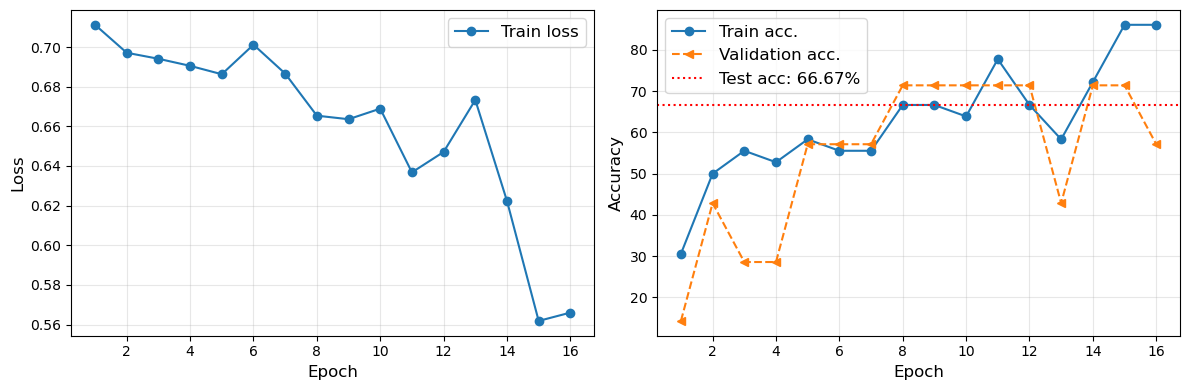

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Simple training history plots
epochs = range(1, len(train_losses) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Training Loss
ax1.plot(epochs, train_losses, '-o', label='Train loss')
ax1.legend(fontsize=12)
ax1.set_xlabel('Epoch', size=12)
ax1.set_ylabel('Loss', size=12)
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy
ax2.plot(epochs, train_accuracies, '-o', label='Train acc.')
ax2.plot(epochs, val_accuracies, '--<', label='Validation acc.')
ax2.axhline(y=test_acc, color='red', linestyle=':', label=f'Test acc: {test_acc:.2f}%')
ax2.legend(fontsize=12)
ax2.set_xlabel('Epoch', size=12)
ax2.set_ylabel('Accuracy', size=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Summary

In [45]:
# Summary
def print_training_summary(train_losses, train_accuracies, val_accuracies, test_accuracy, cm):
    print("\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    
    best_train_epoch = np.argmax(train_accuracies) + 1
    best_val_epoch = np.argmax(val_accuracies) + 1
    
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Best Training Accuracy: {max(train_accuracies):.2f}% (Epoch {best_train_epoch})")
    print(f"Best Validation Accuracy: {max(val_accuracies):.2f}% (Epoch {best_val_epoch})")
    print(f"Final Test Accuracy: {test_accuracy:.2f}%")
    print(f"Total Epochs Trained: {len(train_losses)}")
    print(f"Early Stopping: Epoch {len(train_losses)}")
    
    print(f"\nConfusion Matrix Analysis:")
    print(f"Not Official: {cm[0,0]}/{cm[0].sum()} correct ({cm[0,0]/cm[0].sum()*100:.1f}%)")
    print(f"Official: {cm[1,1]}/{cm[1].sum()} correct ({cm[1,1]/cm[1].sum()*100:.1f}%)")
    print(f"Overall: {(cm[0,0] + cm[1,1])}/{cm.sum()} correct ({test_accuracy:.1f}%)")

print_training_summary(train_losses, train_accuracies, val_accuracies, test_acc, cm)


TRAINING SUMMARY
Final Training Loss: 0.5660
Best Training Accuracy: 86.11% (Epoch 15)
Best Validation Accuracy: 71.43% (Epoch 8)
Final Test Accuracy: 66.67%
Total Epochs Trained: 16
Early Stopping: Epoch 16

Confusion Matrix Analysis:
Not Official: 4/6 correct (66.7%)
Official: 2/3 correct (66.7%)
Overall: 6/9 correct (66.7%)


In [39]:
# save model
model_filename = f"Group_3_CNN_FullModel.ph"

torch.save(model.state_dict(), model_filename)